In [17]:
# Imports
import numpy as np
import rasterio
from pyproj import transform
from rasterio.crs import CRS
from rasterio.warp import transform
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

FILEPATH_PREFIX = "downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031"
CLUSTER_THRESHOLD = 8000

In [18]:
# Read data
dataset_band_1 = rasterio.open(FILEPATH_PREFIX + '_B03_10m.jp2')
dataset_band_2 = rasterio.open(FILEPATH_PREFIX + '_B08_10m.jp2')

In [19]:
# Water Mask calculation
image_band_1 = dataset_band_1.read(1)
image_band_2 = dataset_band_2.read(1)
image_band_1_norm = image_band_1 / np.max(np.abs(image_band_1))
image_band_2_norm = image_band_2 / np.max(np.abs(image_band_2))
image_ndwi = (image_band_1_norm - image_band_2_norm) // (image_band_1_norm + image_band_2_norm + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))) + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))
water_mask = image_ndwi > 0.1

In [20]:
# Clustering
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10, algorithm='kd_tree', n_jobs = -1).fit(water_indexes)
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > CLUSTER_THRESHOLD and k != -1}
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]


[1348    0]
[0 0]
[0 0]
[1726    0]
[ 1 14]
[1727 1729]
[1 0]
[1727 1726]
[1576 1584]
[ 936 1009]
[1369 1562]
[ 79 874]
[15 14]
[1729 1729]
[ 15 553]
[1729 1726]
[1308 1313]
[1428 1426]
[1308  553]
[1428 1726]
[1575 1562]
[930 874]
[1575 1576]
[930 936]
[1367 1348]
[71  0]
[1367 1369]
[71 79]
[1552 1530]
[1140 1176]
[1582 1579]
[1038 1056]
[1575 1579]
[1078 1056]
[1556 1552]
[1131 1140]
[1318 1313]
[1423 1426]
[1318 1328]
[1423 1416]
[1335 1328]
[1410 1416]
[1513 1530]
[1200 1176]
[1513 1489]
[1200 1230]
[1390 1361]
[1352 1386]
[1583 1584]
[1026 1009]
[1583 1582]
[1026 1038]
[1571 1567]
[1092 1105]
[1571 1575]
[1092 1078]
[1559 1567]
[1124 1105]
[1559 1556]
[1124 1131]
[1360 1361]
[1387 1386]
[1360 1335]
[1387 1410]
[1431 1489]
[1302 1230]
[1431 1390]
[1302 1352]


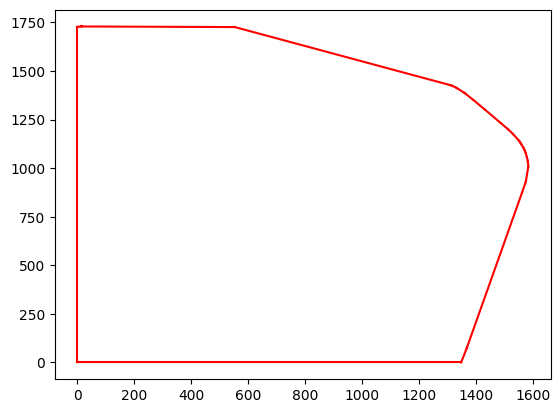

In [41]:
# Geometry
hulls_pixels = []
centroids = []
surface_areas = []

for index in cluster_indexes_above_thre:
    zipped_water_clusters = zip(water_indexes, clusters.labels_)
    pixels_in_cluster = []
    for point, cluster_idx in zipped_water_clusters:
        if cluster_idx == index:
            pixels_in_cluster.append([point[1], point[0]]) 

    pixels_in_cluster = np.array(pixels_in_cluster)

    hull = ConvexHull(pixels_in_cluster)
    hull_pixels = []
    for s in hull.simplices:
        hull_pixels.append([pixels_in_cluster[s, 0], pixels_in_cluster[s, 1]])
    hulls_pixels.append(hull_pixels)

    cx = np.mean(pixels_in_cluster[:, 1])
    cy = np.mean(pixels_in_cluster[:, 0])
    centroids.append([cx, cy])

    surface_area = len(pixels_in_cluster) * 100
    surface_areas.append(surface_area)

import matplotlib.pyplot as plt

# for p in hulls_pixels[0]:
#     print(p[0])
#     print(p[1])
#     plt.plot(p[0], p[1], 'bx', ms = 6)
# plt.show()


for p in hulls_pixels[0]:
    print(p[0])
    print(p[1])
    #plt.plot(p[0], p[1], 'bx', ms = 6)
    #plt.plot(p[0], p[1])
    plt.plot(p[0], p[1], 'r-')
plt.show()

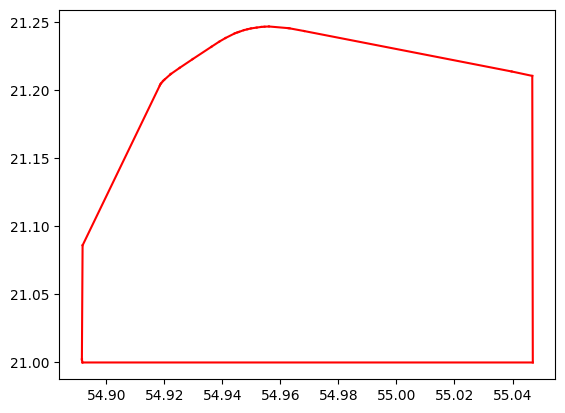

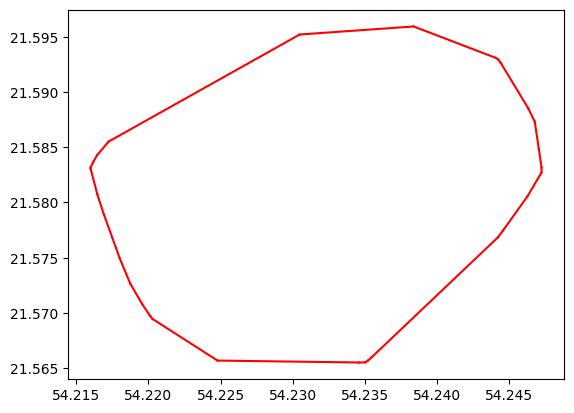

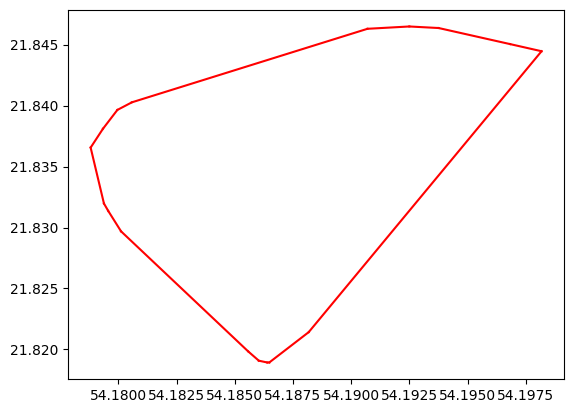

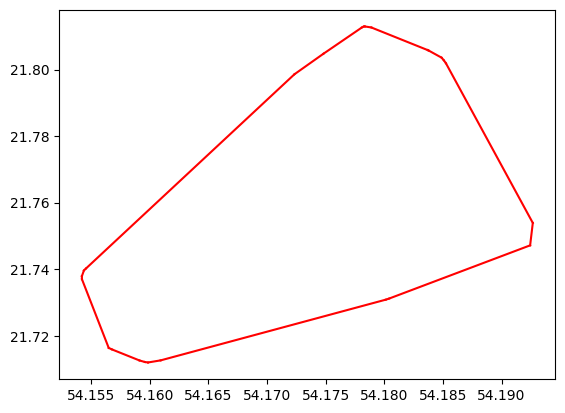

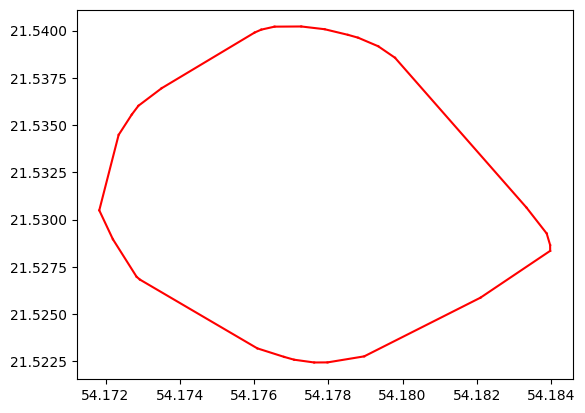

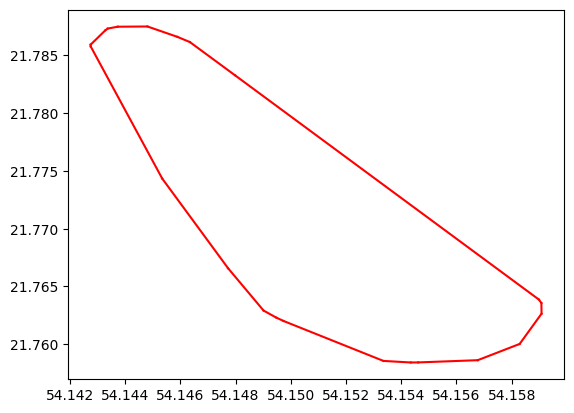

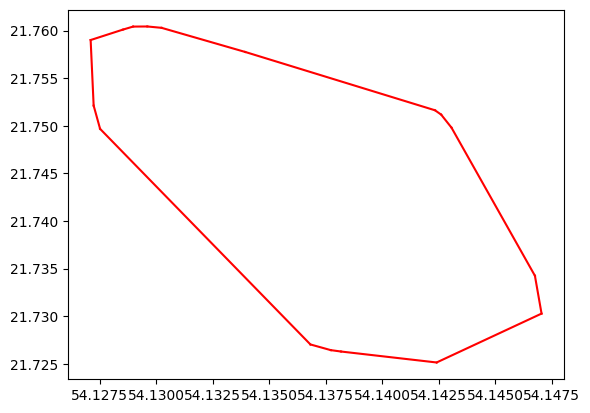

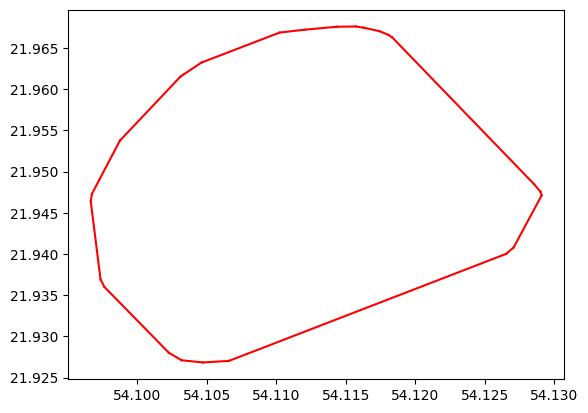

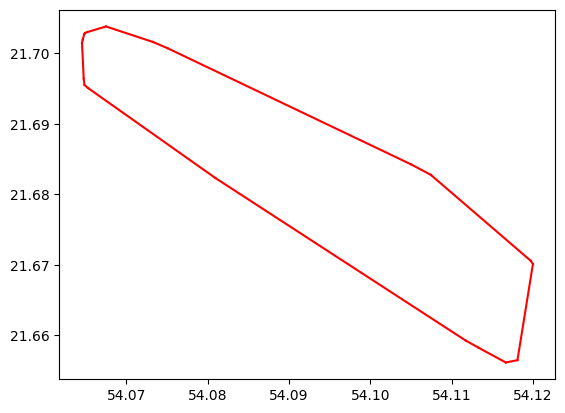

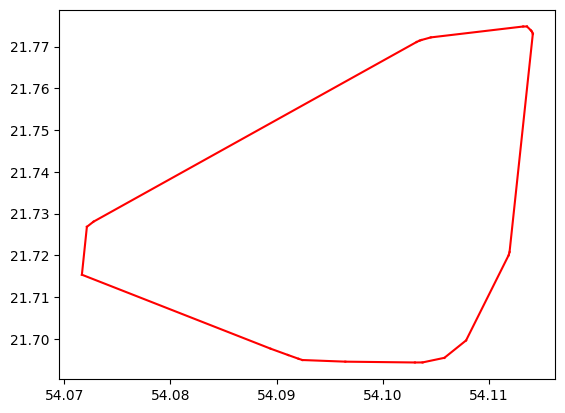

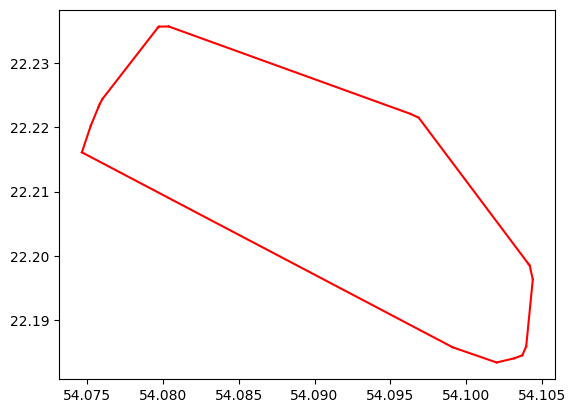

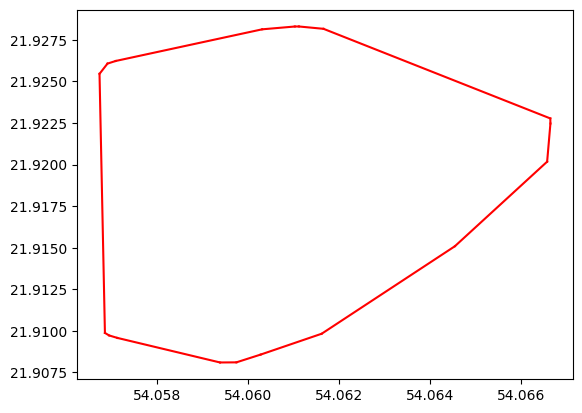

"\nfor p in real_coords_hulls_pixels_first:\n    print(p)\n    plt.plot(p[0], p[1], 'bx', ms = 6)\nfor p in real_coords_hulls_pixels_second:\n    print(p)\n    plt.plot(p[0], p[1], 'rx', ms = 6)\n"

In [44]:
# Real Coords calculation
real_coords_hulls_pixels = []
real_coords_centroids = []

new_crs = CRS.from_epsg(4326)

data_transform = dataset_band_1.transform
move_to_real_coords = lambda water_idx: data_transform * water_idx

#hulls
for n in hulls_pixels:
    real_coords_hulls_pixels_first = []
    real_coords_hulls_pixels_second = []
    real_coords_hulls_pixels_connected = []

    #transformed_hulls_pixels_first = np.array([move_to_real_coords(np.array([xi[0][0], xi[1][0]])) for xi in hulls_pixels[0]])
    transformed_hulls_pixels_first = np.array([move_to_real_coords(np.array([xi[0][0], xi[1][0]])) for xi in n])
    for hull_pixels in transformed_hulls_pixels_first:
        real_coords_hull_pixels = transform(dataset_band_2.crs, new_crs, xs=[hull_pixels[0]], ys=[hull_pixels[1]])
        real_coords_hulls_pixels_first.append([real_coords_hull_pixels[1][0], real_coords_hull_pixels[0][0]])
    #print(real_coords_hulls_pixels_first)


    #transformed_hulls_pixels_second = np.array([move_to_real_coords(np.array([xi[0][1], xi[1][1]])) for xi in hulls_pixels[0]])
    transformed_hulls_pixels_second = np.array([move_to_real_coords(np.array([xi[0][1], xi[1][1]])) for xi in n])
    for hull_pixels in transformed_hulls_pixels_second:
        real_coords_hull_pixels = transform(dataset_band_2.crs, new_crs, xs=[hull_pixels[0]], ys=[hull_pixels[1]])
        real_coords_hulls_pixels_second.append([real_coords_hull_pixels[1][0], real_coords_hull_pixels[0][0]])
    #print(real_coords_hulls_pixels_second)

    #print(len(real_coords_hulls_pixels_first))
    #print(len(real_coords_hulls_pixels_second))

    index = 0
    side = 1 # 1 - first to second, 2 - second to first
    while (len(real_coords_hulls_pixels_connected) < len(real_coords_hulls_pixels_first)):
        if len(real_coords_hulls_pixels_connected) == len(real_coords_hulls_pixels_first) - 1:
            real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_first[0])
        else:
            if side == 1:
                real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_first[index])
            else:
                real_coords_hulls_pixels_connected.append(real_coords_hulls_pixels_second[index])


            for i in range(len(real_coords_hulls_pixels_first)):
                if side == 1:
                    if real_coords_hulls_pixels_second[index] == real_coords_hulls_pixels_first[i]:
                        index = i
                        break
                    elif real_coords_hulls_pixels_second[index] == real_coords_hulls_pixels_second[i] and index != i:
                        index = i
                        side = 2
                        break
                else:
                    if real_coords_hulls_pixels_first[index] == real_coords_hulls_pixels_first[i] and index != i:
                        index = i
                        side = 1
                        break
                    elif real_coords_hulls_pixels_first[index] == real_coords_hulls_pixels_second[i]:
                        index = i
                        break

    #print(real_coords_hulls_pixels_connected)
    real_coords_hulls_pixels.append(real_coords_hulls_pixels_connected)

transformed_centroid = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in centroids])
for centroid in transformed_centroid:
    real_coords_centroid = transform(dataset_band_2.crs, new_crs, xs=[centroid[0]], ys=[centroid[1]])
    real_coords_centroids.append([real_coords_centroid[1][0], real_coords_centroid[0][0]])


import matplotlib.pyplot as plt

# for i in range(len(real_coords_hulls_pixels_first)):
#     plt.plot([real_coords_hulls_pixels_first[i][0], real_coords_hulls_pixels_second[i][0]], [real_coords_hulls_pixels_first[i][1], real_coords_hulls_pixels_second[i][1]], 'r-')
#     #plt.plot(real_coords_hulls_pixels_first[i], real_coords_hulls_pixels_second[i], 'bx', ms = 6)
# plt.show()
for n in range(len(real_coords_hulls_pixels)):
    for i in range(len(real_coords_hulls_pixels[n])):
        plt.plot([real_coords_hulls_pixels[n][i][0], real_coords_hulls_pixels[n][(i + 1) % len(real_coords_hulls_pixels[n])][0]], [real_coords_hulls_pixels[n][i][1], real_coords_hulls_pixels[n][(i + 1) % len(real_coords_hulls_pixels[n])][1]], 'r-')
    plt.show()

'''
for p in real_coords_hulls_pixels_first:
    print(p)
    plt.plot(p[0], p[1], 'bx', ms = 6)
for p in real_coords_hulls_pixels_second:
    print(p)
    plt.plot(p[0], p[1], 'rx', ms = 6)
'''


In [46]:
print('surface_areas (m^2):')
print(surface_areas)
print('real_coords_centroids:')
print(real_coords_centroids)
print('real_coords_hulls_pixels:')
print(real_coords_hulls_pixels)

surface_areas (m^2):
[189114000, 4299600, 1405100, 8350800, 964100, 1161700, 1311900, 3483100, 2451500, 4098600, 3514900, 906000]
real_coords_centroids:
[[54.99154618440803, 21.117645800653854], [54.69860640185011, 22.40465676782657], [54.548156059323304, 22.473574488141583], [54.590174726990035, 22.49479167287952], [54.72602517156922, 22.500081403940044], [54.58451820415531, 22.539512429627408], [54.601610103141205, 22.55871159724081], [54.4802150155009, 22.604897896499445], [54.635813809422814, 22.638926868859812], [54.609604407366916, 22.63381653870706], [54.325366095514084, 22.624227312997693], [54.49501147908467, 22.688454620636087]]
real_coords_hulls_pixels:
[[[55.04680377907508, 21.210661412936883], [55.04698603153837, 20.999686980376268], [54.891879612411394, 20.999688184191733], [54.89178974688776, 20.99984409244292], [54.891610000933234, 21.001870882354975], [54.891609998432685, 21.002026789217787], [54.891849245770096, 21.08590520142625], [54.918488798035504, 21.203750188483

In [23]:
# Real Coords calculation
data_transform = dataset_band_1.transform
move_to_real_coords = lambda water_idx: data_transform * water_idx

zipped_water_clusters = zip(water_indexes, clusters.labels_)
water_cluster_points = {}
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx not in water_cluster_points and cluster_idx in cluster_indexes_above_thre:
        water_cluster_points[cluster_idx] = point

water_indexes_real_coords = np.array([move_to_real_coords(np.array([xi[1], xi[0]])) for xi in water_cluster_points.values()])

zipped_final_result = zip(water_cluster_points, water_indexes_real_coords)
new_crs = CRS.from_epsg(4326)

export_to_db_dic = {}

for result in list(zipped_final_result):
    new_coo = transform(dataset_band_2.crs, new_crs, xs=[result[1][0]], ys=[result[1][1]])
    export_to_db_dic[result[0]] = [new_coo[1][0], new_coo[0][0]]

export_to_db_dic


    


{0: [55.04698603153837, 20.999686980376268],
 54: [54.2472672223876, 21.58271842653359],
 59: [54.1983677088979, 21.84216306885771],
 64: [54.19266073865039, 21.75391702182309],
 72: [54.18397463696728, 21.52834905566329],
 85: [54.15908090195105, 21.7626483874136],
 99: [54.14705799974809, 21.730276297258655],
 108: [54.12909932825082, 21.947117652384584],
 124: [54.119998050119435, 21.669518372196475],
 134: [54.114164996823376, 21.772991169832792],
 148: [54.104409713653844, 22.19631851699858],
 195: [54.06664345066743, 21.922469135107754]}